# EDA for Credit Deafult Predicton

Author: Sharon

In [28]:
# Data Handling
import pandas as pd
import numpy as np
import gzip
from sklearn.model_selection import train_test_split

# Ploting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.express as px

# System
import os
from os import path
import sys
import warnings
warnings.filterwarnings('ignore')


In [29]:
# Define Variables for files and paths

MAIN_DIR = path.dirname(__vsc_ipynb_file__)
OUTPUT_DIR = path.join(MAIN_DIR,"output")
INPUT_DIR = path.join(MAIN_DIR, "data")

DF_PATH = path.join(INPUT_DIR, "definitely_not_from_kaggle_loan_default_dataset.csv.gz")

In [30]:
# import functions from utils.py

sys.path.append(MAIN_DIR)
from utils import *

# Read and Wrangle Data

From Test file: The data presented are 25k dummy of loans with their corresponding date of application (credit_application_date), a label if
the client defaulted (default) and 254 features. The objective is to create a model to predict default.

In [31]:
df_init = pd.read_csv(DF_PATH, compression='gzip') # GZIP is necessary to decompress .csv.gz files
df_init['credit_application_date'] = pd.to_datetime(df_init['credit_application_date']) # Convert to date type

df_init = df_init.drop_duplicates() # Drop all-duplicated entries

In [32]:
df_init.info() # Run df.info(verbose=True) for in-detail columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Columns: 257 entries, uuid to activity_pattern_11_weekdaynight_month_9_no_aggregation
dtypes: datetime64[ns](1), float64(252), object(4)
memory usage: 49.0+ MB


The DF has 4 categorical columns, one date column and the target variable column Default.


In [33]:
[col for col in df_init.select_dtypes(include=['object', 'category']).columns] # Get categorical features

['uuid',
 'activity_date_36_month_1_no_aggregation',
 'location_cluster_03_month_1_most_frequent',
 'contract_type_1_month_1_no_aggregation']

The variable `uuid` is the register id, which doesn't provide much information, while `activity_date_36_month_1_no_aggregation` is a date and should be transformed.

In [34]:
# Convert to appropriate type

df_init['activity_date_36_month_1_no_aggregation'] = pd.to_datetime(
    df_init['activity_date_36_month_1_no_aggregation']
) # convert to date format

df_init['location_cluster_03_month_1_most_frequent'] = df_init['location_cluster_03_month_1_most_frequent'].astype('category')
df_init['contract_type_1_month_1_no_aggregation'] = df_init['contract_type_1_month_1_no_aggregation'].astype('category')

In [35]:
df_init.select_dtypes(['category']).apply(pd.Series.nunique, axis = 0)

location_cluster_03_month_1_most_frequent    9
contract_type_1_month_1_no_aggregation       3
dtype: int64

In [36]:
# Split data for prediction and testing/training
df = df_init[df_init['default'].notna()].copy() # Training/testing set
df_prediction = df_init[df_init['default'].isna()].copy() # Set for prediction 

# Remove rows that are all NA except, credit_application_date, uuid, default
exclude_cols = ['default', 'credit_application_date', 'uuid']
df = df.loc[~df.drop(columns=exclude_cols).isna().all(axis=1)]

df.shape

(18605, 257)

In [37]:
df.describe(include=['O','category'])

uuid  \
count                                  18605   
unique                                 18605   
top     40319a6f-0697-4217-b170-ddc9bfed4c67   
freq                                       1   

       location_cluster_03_month_1_most_frequent  \
count                                      17756   
unique                                         9   
top                                     REGION_9   
freq                                        8702   

       contract_type_1_month_1_no_aggregation  
count                                   12609  
unique                                      3  
top                                    TYPE_1  
freq                                     8233

The target variable is a binary variable that takes `0 = 'not-default'` and `1 = 'default'`, considering the data type is expected to have a higly imbalanced data set as default events are not as common, for the modeling stage this should be considered by using some resampling techique and a model that is robust against imbalanced datasets.

In [38]:
# Convert DEfault to integer
df['default'] = df['default'].astype(int)

df['default'].value_counts()

default
0    15424
1     3181
Name: count, dtype: int64

## Missing Values

In [39]:
# Check columns with NA's
na_counts = count_na(df, verbose=True)# Get na proportions per columns
na_drop = na_counts.index[na_counts>80].to_list() # Drop columns that have more than 80% of 
na_drop



Number of columns with missing values: 254


['billing_pattern_03_last_12_months_mean',
 'billing_pattern_08_last_12_months_mean',
 'line_balance_type_04_last_6_months_max']

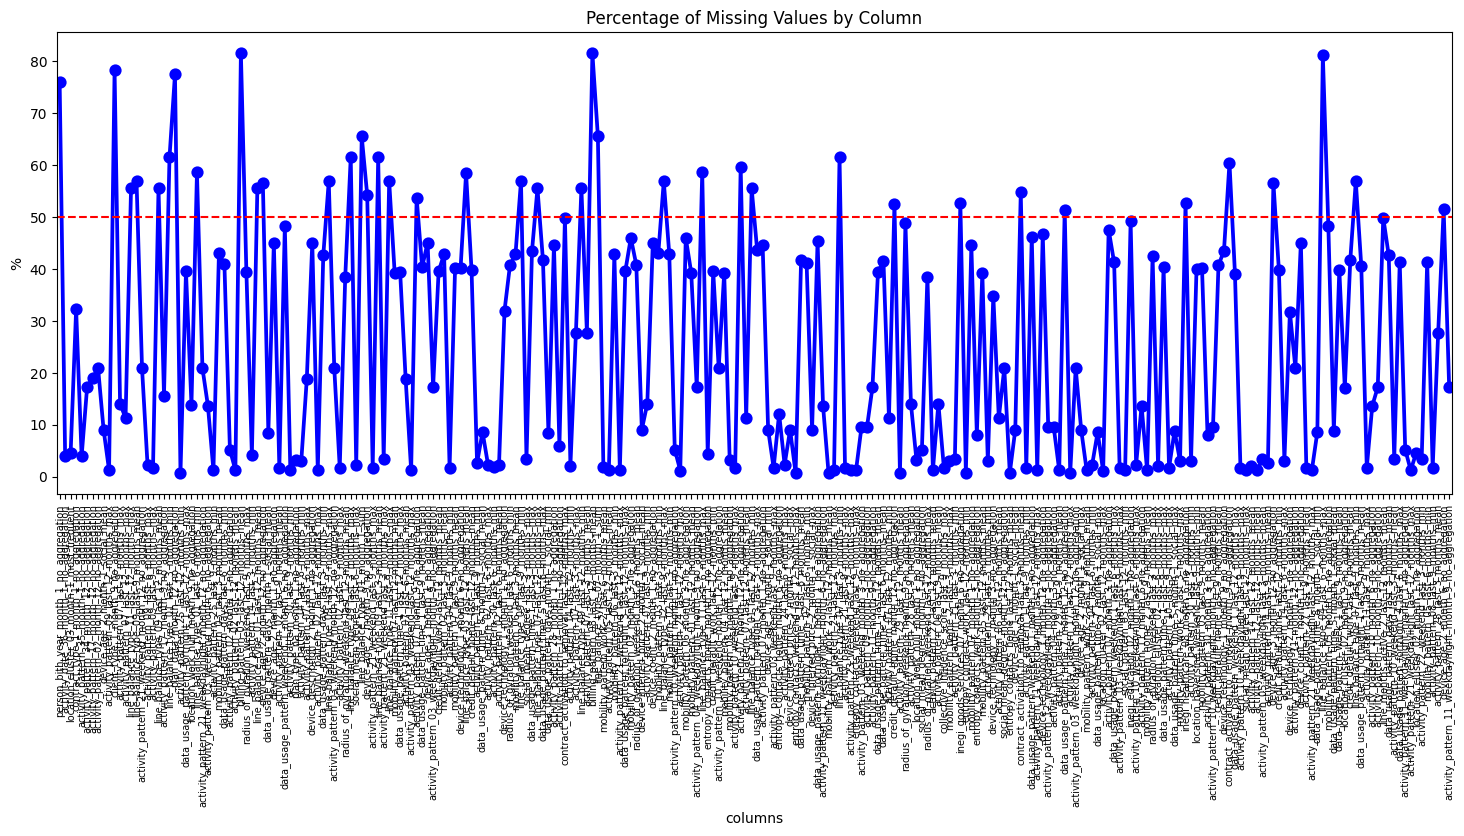

In [40]:
plot_na(na_counts=na_counts, threshold=50)

There are many columns with NA values. But on the instructions it was mentioned that the NA values for default variable correspond to the testing set (around 21.5% but in reality we have 21.112%)

There are several ways to handle NA data:
- Compute imputations: if the variable is numerical some linear interpolation, mean or any other measure can be applied. If the variable is categorical, the mode is a good option or use a flag. When doing the imputations if group patterns are discovered, te imputation can be done by group.

- Drop columns that have a majority percentage of NA values, as it might not give useful information

- Use models that handle natively the NA, such as XGBoost or LightGBM

In the current example, as all the variables have NA both in train and testing sets, a model that handles NA natively will be used and also the columns with more than 80% NA will be dropped.

the variable `uuid` also will be dropped as is an id

In [41]:
# Drop columns with more than 80% of NA and uuid

df_cln = (
    df
    #.drop(columns=na_drop+['uuid'])
    .copy()
)

df_cln.shape

(18605, 257)

# Add time features

Some time features will be added. 
According to the seasonality of the data and some other properties of the time series more features could be considered. 

In [42]:
date_columns = df_cln.select_dtypes(include=['datetime64', 'datetime']).columns
numerical_columns = df_cln.select_dtypes(include=['number']).columns

# Extract temporal features, we could extract more features that are relevant according to seasonal patterns 
for col in date_columns:
    df_cln[f'{col}_year'] = df_cln[col].dt.year
    df_cln[f'{col}_month'] = df_cln[col].dt.month
    df_cln[f'{col}_dayofweek'] = df_cln[col].dt.dayofweek

    #Same for prediction df
    df_prediction[f'{col}_year'] = df_prediction[col].dt.year
    df_prediction[f'{col}_month'] = df_prediction[col].dt.month
    df_prediction[f'{col}_dayofweek'] = df_prediction[col].dt.dayofweek

# Split data

Is preferably to do the EDA on only the train set to avoid data leakage


In [43]:
# stratified split to keep proportion of default variable (is umbalanced)
train_df, test_df = train_test_split(df_cln, test_size=0.215, stratify=df['default'], random_state=42) 

print("Training Set:")
print(train_df.shape[0])
print(train_df['default'].value_counts()/train_df.shape[0])
print("\nTest Set:")
print(test_df.shape[0])
print(test_df['default'].value_counts()/test_df.shape[0])

Training Set:
14604
default
0    0.829019
1    0.170981
Name: count, dtype: float64

Test Set:
4001
default
0    0.829043
1    0.170957
Name: count, dtype: float64


# EDA

In [44]:
interactive_stacked_plot(train_df,
                         column='contract_type_1_month_1_no_aggregation',
                          group='default',
                          title="Default stauts vs contract type")

There is a relation between contract type and default, Type 3 contrast have lower default rate.

In [45]:
interactive_stacked_plot(train_df,
                         column='location_cluster_03_month_1_most_frequent',
                          group='default',
                          title='Default status vs region')

Default rates appear to be fairly consistent across regions, although regions 1 and 2 show slightly higher rates.

In [46]:
interactive_stacked_plot(train_df,
                         column='credit_application_date_year',
                         group='default',
                         title='Default status vs year applied'
                         )

Default rates are mostly even for both years included on the data set, older credits (those of 2022) seem to have slightly lower default rate, but two years might not be enough information to decide if there is a relation between year of application and default. 

Also, default rates seem to be even cross the months, altough credit emited on October seem to have lower default rates.

<Axes: xlabel='person_bith_year_month_1_no_aggregation', ylabel='Count'>

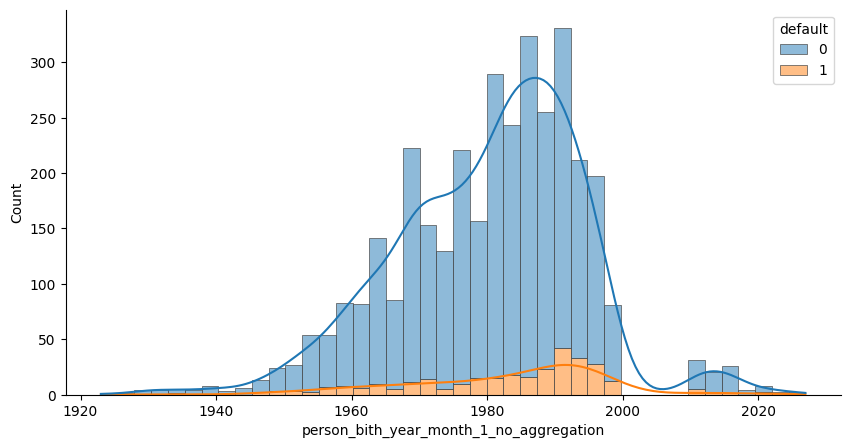

In [47]:
# Default per bith year

f, ax = plt.subplots(figsize=(10, 5))
sns.despine(f)

sns.histplot(
    train_df,
    x="person_bith_year_month_1_no_aggregation", hue="default",
    multiple="stack",
    kde=True,
    edgecolor=".3",
    linewidth=.5
)


In [48]:
# Plot
interactive_stacked_plot(
    train_df,
    column='credit_application_date_month',
    group='default',
    title='Default status vs month applied'
)

In [49]:
default_count_by_ym = train_df.copy()

# Create month-year labels
default_count_by_ym['month_year'] = default_count_by_ym['credit_application_date_year'].astype(str) + '-' + \
                   default_count_by_ym['credit_application_date_month'].astype(str).str.zfill(2)

# Plot
interactive_stacked_plot(
    default_count_by_ym,
    column='month_year',
    group='default',
    title='Default status vs date applied (mm-yy)'
)

In [50]:
## For interactive plot
# fig = px.histogram(
#     train_df,
#     x="person_bith_year_month_1_no_aggregation",
#     color="default",
#     barmode="stack",
#     template="simple_white",
#     category_orders={"default": [1, 0]},
#     color_discrete_map={
#         0: '#1f77b4', 
#         1: '#ff7f0e'   
#     }
# )

# # Customize the layout
# fig.update_traces(
#     opacity=1,
#     marker=dict(
#         line=dict(color='#4d4d4d', width=0.5) 
#     )
# )

# fig.update_layout(
#     bargap=0.1,  # Add small gaps between bars
#     margin=dict(l=50, r=20, t=20, b=50)  # Adjust margins
# )

# fig.show()

<Axes: xlabel='person_bith_year_month_1_no_aggregation', ylabel='Count'>

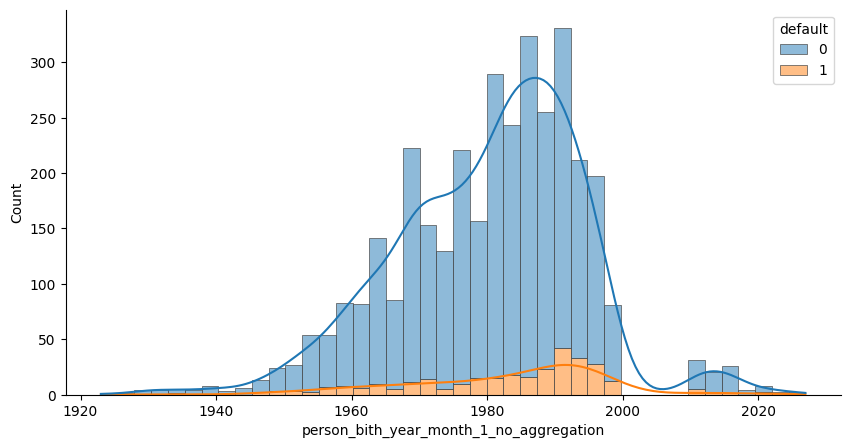

In [51]:
# Default per birth year

default_count_by_ym = train_df.groupby([
    'credit_application_date_year',
    'credit_application_date_month'
])['default'].count()

f, ax = plt.subplots(figsize=(10, 5))


sns.despine(f)



sns.histplot(
    train_df,
    x="person_bith_year_month_1_no_aggregation", hue="default",
    multiple="stack",
    kde=True,
    edgecolor=".3",
    linewidth=.5
)


The birth years with higher default rates are 1992 & 1993.

In general, this variable has high variability, but as the birth year increases (age decreases) seems to be a higher deafult rate, until 1996 where default rates start to drop.

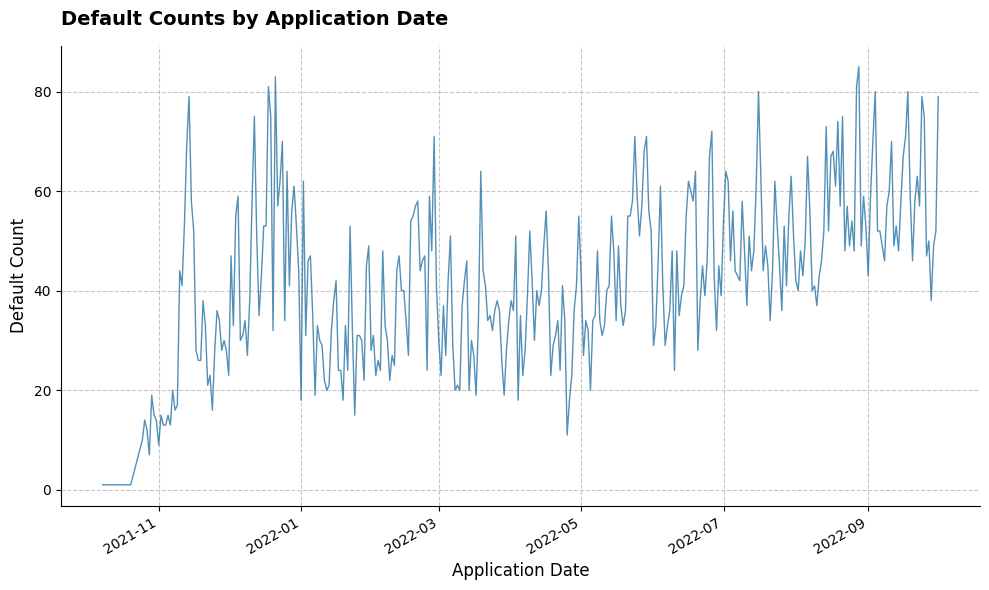

In [52]:

fig, ax = plt.subplots(figsize=(10, 6), dpi=100)

defaults_by_date = (train_df.groupby('credit_application_date')['default']
                           .count()
                           .sort_index())

defaults_by_date.plot(
    ax=ax,
    color='#2874A6', 
    linewidth=1,
    alpha=0.8
)

ax.set_title('Default Counts by Application Date', 
             fontsize=14, 
             pad=15,
             fontweight='bold',
             loc='left')
ax.set_xlabel('Application Date', fontsize=12)
ax.set_ylabel('Default Count', fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()

# Add grid for better readability
ax.grid(True, linestyle='--', alpha=0.7)

As the features are obfuscated and lack feature descriptions, we won't conduct further exploration on the other variables that are harder to interpret. However, there are several other steps that should be considered in the EDA:

- Using pair plots to explore correlations in the data by default type
- Creating distribution plots (such as box plots and violin plots) to describe the behavior of the data by default
- Generating a correlogram to examine linear correlations and identify strong multicollinearity between variables, helping decide which variables to keep and avoid redundancy
- VIF (Variance Inflation Factor) on the variables to identify problematic correlations.

For this exercise, PCA will be used to reduce dimensionality, as the presence of 254 variables and the likely correlations between these variables makes PCA an appropriate technique for dimensional reduction.



## correlation Analysis


In [53]:
# compute correlation for numerical variables
numerical_columns = train_df.select_dtypes(include=['number']).columns
df_corr = train_df[numerical_columns].corr()

# Plot correlogram
fig = px.imshow(df_corr,
                labels=dict(color="Correlation"),
                color_continuous_scale='RdBu',
                aspect='auto',  
                text_auto=True)

# Customize layout
fig.update_layout(
    title='Correlation Matrix',
    xaxis_title='Variables',
    yaxis_title='Variables',
    width=1200,
    height=1200
)

fig.show()

As there are a lot of variables, is not that useful to visualize.

In [54]:
# Save datasets
os.makedirs(OUTPUT_DIR, exist_ok=True)

df_prediction.set_index('uuid').to_csv(os.path.join(OUTPUT_DIR, 'df_prediction.csv'))

# Drop Date columns there are already have some time features
df_cln.drop(columns = date_columns).to_csv(os.path.join(OUTPUT_DIR, 'df_train_test.csv'), index=False)